In [ ]:
%load_ext jupyter_black

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
    QuantileTransformer,
)
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
import warnings

warnings.filterwarnings("ignore")

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
import platform

if platform.system() == "Windows":
    prefix = "data/"
else:
    prefix = "data\\"

train = pd.read_csv(prefix + "train.csv", encoding="utf-8")
data_test = pd.read_csv(prefix + "test.csv", encoding="utf-8")
train.head(5)

,Name,SexuponOutcome,AnimalType,AgeuponOutcome,Breed,Color,DateTime,Outcome,ID
0,Socks,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Black/White,2014-06-11 14:36:00,0,0
1,Vera,Intact Female,Cat,1 month,Domestic Shorthair Mix,Tortie/White,2014-07-18 08:10:00,3,1
2,Biscuit,Neutered Male,Dog,3 months,Chihuahua Shorthair Mix,Yellow,2016-01-02 17:28:00,2,2
3,Kitten,Spayed Female,Cat,2 years,Domestic Shorthair Mix,Calico,2014-02-19 17:27:00,0,3
4,NaN,Neutered Male,Cat,2 months,Domestic Shorthair Mix,Orange Tabby,2014-07-21 17:34:00,0,4


In [ ]:
def pandas_dates2number(date_series: pd.Series):
    return pd.to_datetime(date_series).values.astype(np.int64) // 10**9

In [ ]:
def string_to_age(string):
    if not isinstance(string, str):
        return string
    N, unit = string.split(" ")
    if unit == "year" or unit == "years":
        unit = 365.0
    elif unit == "month" or unit == "months":
        unit = 30
    elif unit == "week" or unit == "weeks":
        unit = 7
    else:
        unit = 1
    return float(N) * unit

In [ ]:
common_breeds = train.Breed.value_counts()[train.Breed.value_counts() > 10].index
common_colors = train.Color.value_counts()[train.Color.value_counts() > 10].index

In [ ]:
def clean_dataframe(df):

    df.index = df.ID

    # Добавим доп категорию для пород, которые встречаются чрезвычайно редко
    df["BreedUpd"] = df.Breed.map(lambda x: x if x in common_breeds else "Other")
    df["ColorUpd"] = df.Color.map(lambda x: x if x in common_breeds else "Other")

    df["SexuponOutcome"][df["SexuponOutcome"].isna()] = "Unknown"

    df.DateTime = pandas_dates2number(df.DateTime)
    df["AgeuponOutcome"] = df.AgeuponOutcome.map(lambda x: string_to_age(x))
    median = df["AgeuponOutcome"][df["AgeuponOutcome"].notna()].median()
    df["AgeuponOutcome"].fillna(median, inplace=True)

    # Разделяем животных на возрастные группы. Кошки и собаки имеют примерно одинаковые
    # продолжительности жизни и скорость взросления, поэтому за источник была взята
    # таблица из сайта https://thecatdoctor.co.uk/cat-health/feline-life-stages/

    bins = [-1, 180, 730, 3650, np.inf]
    labels = ["juvenile", "young", "adult", "old"]
    df["AgeGroup"] = pd.cut(df["AgeuponOutcome"], bins=bins, labels=labels)

    return df.drop(["ID", "Name"], axis=1)

In [ ]:
train = clean_dataframe(train)
data_test = clean_dataframe(data_test)

In [ ]:
train.head()

In [ ]:
train.Breed.value_counts()

In [ ]:
train.BreedUpd.value_counts()

In [ ]:
train.AgeuponOutcome.hist()

In [ ]:
train.AgeuponOutcome.median()

In [ ]:
train.AgeGroup.hist()

In [ ]:
train.DateTime.hist(bins=20)

In [ ]:
cat_cols = [
    "SexuponOutcome",
    "AnimalType",
    "Color",
    "ColorUpd",
    "AgeGroup",
    "Breed",
    "BreedUpd",
]
real_cols = ["AgeuponOutcome"]
time_cols = ["DateTime"]

# для преобразования даты+времени используем QuantileTransformer, т.к. эти данные имеют периодическую природу(т.е. распределены мультимодально)
column_transformer = ColumnTransformer(
    transformers=[
        # (
        #     "ohe",
        #     OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        #     cat_cols,
        # ),
        (
            "ore",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            cat_cols,
        ),
        ("real_scaling", StandardScaler(), real_cols),
        ("time_scaling", QuantileTransformer(random_state=RANDOM_SEED), time_cols),
    ],
    remainder="passthrough",
)

column_transformer_hgb = ColumnTransformer(
    transformers=[
        # One-Hot производит слишком много фич + HistGradientBoosting лучше работает ординальным кодированием
        (
            "ore",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            cat_cols,
        ),
        ("real_scaling", StandardScaler(), real_cols),
        ("time_scaling", QuantileTransformer(random_state=RANDOM_SEED), time_cols),
    ],
    remainder="passthrough",
)

In [ ]:
y_train = train["Outcome"]
data_train = train.drop(["Outcome"], axis=1)

  File "C:\Users\anaki\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7538
           1       0.98      0.93      0.96      6595
           2       0.95      0.96      0.96      3350
           3       0.92      0.96      0.94      1089
           4       0.83      0.98      0.90       138

    accuracy                           0.96     18710
   macro avg       0.93      0.96      0.94     18710
weighted avg       0.96      0.96      0.96     18710

0.9587386424371993


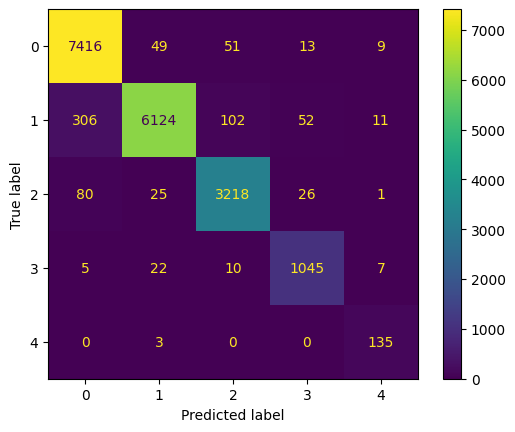

In [ ]:
hgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer_hgb),
        (
            "classifier",
            HistGradientBoostingClassifier(
                class_weight="balanced",
                random_state=RANDOM_SEED,
            ),
        ),
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            RandomForestClassifier(
                class_weight="balanced",
                random_state=RANDOM_SEED,
                n_estimators=1000,
            ),
        ),
    ]
)

# Рассматривался градиентный спуск, но, к сожалению, NaN'ы нужно оставлять((((
# sgd_pipeline = Pipeline(
#     steps=[
#         ("preprocessor", column_transformer),
#         (
#             "classifier",
#             SGDClassifier(
#                 loss="log_loss",
#                 penalty="elasticnet",
#                 class_weight="balanced",
#                 random_state=RANDOM_SEED,
#             ),
#         ),
#     ]
# )

voting_model = VotingClassifier(
    estimators=[
        ("hgb", hgb_pipeline),
        ("rf", rf_pipeline),
        # ("sgd", sgd_pipeline),
    ],
    voting="soft",
    n_jobs=-1,
)

y_pred = voting_model.fit(data_train, y_train).predict(data_train)
print(classification_report(y_train, y_pred))
print(accuracy_score(y_train, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred))

disp.plot()
plt.show()

In [ ]:
preds = voting_model.predict(data_test)

# Create a submission using constant predictions
submission = pd.DataFrame({"ID": data_test.index, "Outcome": preds})

# Save the submission
submission.to_csv("submission.csv", index=False)
# y_pred_test.head()